# Homework №2

This homework will be dedicated to **ASR & Co**.

In general, you may implement any ASR model that was discussed in the lecture,
but we recommend to implement **QuartzNet**.

## **Important aspects (model)**
1) Pay attention on different length of utterances. P.S. **masking**.
    
2) A good ASR is a robust ASR, so we ask you to implement and use at least **4 types of augmentations** (P.S. 2 seminar).

3) Also, to get better quality, we ask you to implement a **beam search** for better decoding.

4) (Bonus) As a bonus you can use **BPE** instead of Char. You can use SentencePiece, HuggingFace or YouTokenToMe.

5) (Bonus) As a bonus you can take pretrained **LM** (or train yourself) and fusing LM with ASR.
    Way of fusing you may choose yourself.

## **Important aspects (code)**
1) You already know about pytorch-lighting (I hope :)) but you are not allowed to use it in this homework.

2) Try to write code more structurally and cleanly !

3) Good logging of experiments save your nerves and time,
    so we ask you to use **W&B** and log at least loss, WER, CER and pairs (audio -- recognized text).
    **Do not remove** the logs until we have checked your work and given you a grade!

4) We also ask you to organize your code in github repo with Docker and setup.py. You can use my template https://github.com/markovka17/dl-start-pack.

5) Your work **must be** reproducable, so fix seed, save the weights of model, and etc.

6) In the end of your work write inference utils. Anyone should be able to take your weight, load it into the model and run it on some audio track.

## Data

1) If you have enough GPU and CPU we recommend to train model on librispeech-100 (100 hours).
    If you poor student your choise is LJSpeech (24 housr) :)

1.1) LJSpeech https://keithito.com/LJ-Speech-Dataset/. Note that audio file is a single-channel 16-bit PCM WAV with a sample rate of 22050 Hz. So, feel free to resample audio in 16000 Hz.
    Target text is **Normalized Transcription** in **transcripts.csv**.

1.2) LibriSpeech https://www.openslr.org/12. Download and use train-clean-100.tar.gz.

Числа: https://drive.google.com/file/d/1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P/view?usp=sharing

CommonVoice Mozilla: https://commonvoice.mozilla.org/en/datasets
Он весит 50 гигабайт. В нем значительно больше коротких записей, что должно ускорить сходимость методов на нем.
Можно обучиться на нем всем или просто отщипнуть себе кусочек.

Все еще настоятельно рекомендую препроцессить датасет и выкидывать все записи длиннее N-секунд (а если вы учите не CTC, то стоит еще дополнительно выкидывать все записи длиннее  K символов), чтобы максимизировать размер батча.

##### config

https://github.com/NVIDIA/NeMo/blob/main/examples/asr/conf/quartznet_15x5.yaml

### Начинаем решение

In [12]:
import pandas as pd
import string
import re

import librosa
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch import distributions
from tqdm import tqdm

from collections import Counter
from IPython import display as display_
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
BATCH_SIZE = 40
NUM_EPOCHS = 50

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### датасет лоадер

In [15]:
class TrainDataset(torch.utils.data.Dataset):
    """Custom competition dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.answers = pd.read_csv(csv_file, '\t')
        self.transform = transform


    def __len__(self):
        return len(self.answers)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        utt_name = 'cv-corpus-5.1-singleword/en/clips/' + self.answers.loc[idx, 'path']
        utt = torchaudio.load(utt_name)[0].squeeze()
        answer = self.answers.loc[idx, 'sentence']

        if self.transform:
            utt = self.transform(utt)

        sample = {'utt': utt, 'answer': answer}
        return sample

In [16]:
class TestDataset(torch.utils.data.Dataset):
    """Custom competition dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.names = pd.read_csv(csv_file, '\t')
        self.transform = transform


    def __len__(self):
        return len(self.names)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        utt_name = 'cv-corpus-5.1-singleword/en/clips/' + self.names.loc[idx, 'path']
        utt = torchaudio.load(utt_name)[0].squeeze()

        if self.transform:
            utt = self.transform(utt)

        sample = {'utt': utt}
        return sample

In [17]:
def transform_tr(wav):
    aug_num = torch.randint(low=0, high=3, size=(1,)).item()
    augs = [
        lambda x: x,
        lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
        lambda x: torchaudio.transforms.Vol(.1)(x)
    ]
    
    return augs[aug_num](wav)

In [18]:
def viz(wav):
    figsize(20, 5)
    plot(wav)
    plt.show()

    display_.display(display_.Audio(wav, rate=40000, normalize=False))

In [19]:
class TextTransform:
    def __init__(self):
        self.char_dict = {}
        self.index_dict = {}
        
        self.char_dict['\''] = 0
        self.index_dict[0] = '\''
        self.char_dict[' '] = 1
        self.index_dict[1] = ' '
        for i, let in enumerate(string.ascii_lowercase):
            self.index_dict[i+2] = let
            self.char_dict[let] = i+2
            
    def text_to_int(self, text):
        labels = []
        for let in text:
            labels.append(self.char_dict[let])
        return labels
    
    def int_to_text(self, labels):
        text = []
        for num in labels:
            text.append(self.index_dict[num])
        return text

In [20]:
import math

In [21]:
def preprocess_data(data):
    text_transform = TextTransform()
    wavs = []
    input_lens = []
    labels = []
    label_lens = []
    
    for el in data:
        wavs.append(el['utt'])
        input_lens.append(math.ceil(mel_len(el['utt'].shape[0]) / 2))   ############# not yet
        label = torch.Tensor(text_transform.text_to_int(re.sub(r'[^\w\s]','', el['answer'].lower()) ))
        labels.append(label)
        label_lens.append(len(label))
        
    wavs = pad_sequence(wavs, batch_first=True)
    labels = pad_sequence(labels, batch_first=True)
    
    return wavs, input_lens, labels, label_lens    

In [22]:
# Loading data and loaders
my_dataset = TrainDataset(csv_file='cv-corpus-5.1-singleword/en/train.tsv', transform=transform_tr)
print('all train+val samples:', len(my_dataset))
test_dataset = TestDataset(csv_file='cv-corpus-5.1-singleword/en/test.tsv', transform=None)

all train+val samples: 12717


In [23]:
#all_lens = []
#for i, el in tqdm(enumerate(my_dataset)):
#    all_lens.append(el['utt'].shape[0])
#    if i == 12710:
#        break

In [24]:
#all_lens2 = np.array(all_lens)
#np.percentile(all_lens2, 95)

# 176256

#####  176256

In [25]:
to_save = []

for i, el in tqdm(enumerate(my_dataset)):
    if el['utt'].shape[0] <= 176256.0:
        to_save.append(i)
    if i == 12710:
        break

12710it [01:02, 204.02it/s]


In [26]:
my_dataset = torch.utils.data.Subset(my_dataset, to_save)
len(my_dataset)

12082

In [27]:
my_dataset, _ = torch.utils.data.random_split(my_dataset, [40, 12042])
test_dataset = my_dataset
train_set = my_dataset
val_set = my_dataset

In [28]:
my_loader = DataLoader(my_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
#train_set, val_set = torch.utils.data.random_split(my_dataset, [40, 10])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=preprocess_data, drop_last=True)
                          #num_workers=2)#, #pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=preprocess_data, drop_last=True) 
                        #num_workers=2), #pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [29]:
melspec = torchaudio.transforms.MelSpectrogram(
    sample_rate=48000,            ### ? ?? ? ?? 
    n_fft=512,
    n_mels=40                     ### debatable for 64
).to(device)

melspec_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=48000, n_fft=512, n_mels=40),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35),
).to(device)

In [30]:
#win_len=512, hop_len=256
def mel_len(x):
    return int((x - 512)/256) + 3

#### experiments field

In [31]:
'''from tqdm import tqdm

for i, (wavs, wavs_len, answ, answ_len) in tqdm(enumerate(train_loader)):
    # all to GPU

    #print(i)
    #print(wavs.shape)
    #print(wavs_len)
    transformed = torch.log(melspec_transforms(wavs) + 1e-9)
    ##################################################3print(transformed.device)
    #print(transformed.shape)
    if mel_len(wavs.shape[1]) != transformed.shape[2]:
        print("STAP THIS", mel_len(wavs.shape[1]), transformed.shape[2])
        break
    #plt.figure()
    #plt.title(ex[0])
    #viz(ex['utt'].squeeze_())
    #plt.show()
'''

'from tqdm import tqdm\n\nfor i, (wavs, wavs_len, answ, answ_len) in tqdm(enumerate(train_loader)):\n    # all to GPU\n\n    #print(i)\n    #print(wavs.shape)\n    #print(wavs_len)\n    transformed = torch.log(melspec_transforms(wavs) + 1e-9)\n    ##################################################3print(transformed.device)\n    #print(transformed.shape)\n    if mel_len(wavs.shape[1]) != transformed.shape[2]:\n        print("STAP THIS", mel_len(wavs.shape[1]), transformed.shape[2])\n        break\n    #plt.figure()\n    #plt.title(ex[0])\n    #viz(ex[\'utt\'].squeeze_())\n    #plt.show()\n'

### Играю в свертки

In [32]:
utt_name = 'cv-corpus-5.1-singleword/en/clips/common_voice_en_21878660.mp3'
utt = torchaudio.load(utt_name)[0].squeeze()
mel_spec = melspec(utt)

In [33]:
mel_spec.unsqueeze_(0).shape

torch.Size([1, 40, 298])

torch.Size([1, 250, 298])


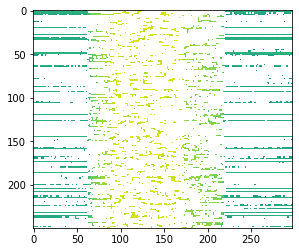

In [34]:
my_layer = torch.nn.Conv1d(40, 250, kernel_size=39, dilation=2, padding=38)

res1 = my_layer(mel_spec)

print(res1.shape)

plt.figure()
plt.imshow(torch.log(res1.squeeze().detach()))
plt.show()

In [35]:
my_layer.weight.shape

torch.Size([250, 40, 39])

#### separable:

In [36]:
mel_spec = melspec(utt)
mel_spec.unsqueeze_(0).shape

torch.Size([1, 40, 298])

1 res shape torch.Size([1, 40, 298])
2 res shape torch.Size([1, 240, 298])
1 layer weights shape torch.Size([40, 1, 33])
2 layer weights shape torch.Size([240, 40, 1])


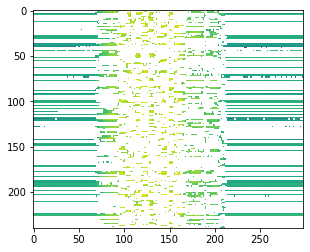

In [37]:
my_layer = torch.nn.Conv1d(40, 40, kernel_size=33, groups=40, dilation=2, padding=32) ### (k_s - 1) / 2
res = my_layer(mel_spec)                                                              ### (k_s - 1) for dil=2

print('1 res shape', res.shape) 

sec_layer = torch.nn.Conv1d(40, 240, kernel_size=1) # gr?
res = sec_layer(res)

print('2 res shape', res.shape) 


print('1 layer weights shape', my_layer.weight.shape)
print('2 layer weights shape', sec_layer.weight.shape)


plt.figure()
plt.imshow(torch.log(res.squeeze().detach()))
plt.show()

In [38]:
240 * 40 * 33 

316800

In [39]:
# 240 * 33 + 240 * 240 = 65520 - неправильно!

In [40]:
40 * 33 + 40 * 240

10920

### Модель

In [41]:
import torch
import torchvision
import numpy as np
import random

import torch.nn as nn
import torch.nn.functional as F

In [42]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
set_seed(21)

In [43]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [44]:
def conv_bn_act(in_size, out_size, kernel_size, stride=1, dilation=1):
    return nn.Sequential(
        nn.Conv1d(in_size, out_size, kernel_size, stride, dilation=dilation),
        nn.BatchNorm1d(out_size),
        nn.ReLU()
    )


def sepconv_bn(in_size, out_size, kernel_size, stride=1, dilation=1, padding=None):
    if padding is None:
        padding = (kernel_size-1)//2
    return nn.Sequential(
        torch.nn.Conv1d(in_size, in_size, kernel_size, 
                        stride=stride, dilation=dilation, groups=in_size,
                        padding=padding),
        torch.nn.Conv1d(in_size, out_size, kernel_size=1),
        nn.BatchNorm1d(out_size)
    )

In [45]:
class QnetBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size, stride=1,
                R=5):
        super().__init__()
        
        self.layers = nn.ModuleList(sepconv_bn(in_size, out_size, kernel_size, stride))
        for i in range(R - 1):
            self.layers.append(nn.ReLU())
            self.layers.append(sepconv_bn(out_size, out_size, kernel_size, stride))
        self.layers = nn.Sequential(*self.layers)
        
        self.residual = nn.ModuleList()
        self.residual.append(torch.nn.Conv1d(in_size, out_size, kernel_size=1))         # requires checking
        self.residual.append(torch.nn.BatchNorm1d(out_size))
        self.residual = nn.Sequential(*self.residual)
    
    def forward(self, x):
        return F.relu(self.residual(x) + self.layers(x))

In [46]:
class QuartzNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
                    
                  #conv_bn_act(40, 256, kernel_size=33, stride=2)
        self.c1 = sepconv_bn(40, 256, kernel_size=33, stride=2)
                  
        
        self.blocks = nn.Sequential(
                #         in   out  k   s  R
                QnetBlock(256, 256, 33, 1, R=5),
                QnetBlock(256, 256, 39, 1, R=5),
                QnetBlock(256, 512, 51, 1, R=5),
                QnetBlock(512, 512, 63, 1, R=5),
                QnetBlock(512, 512, 75, 1, R=5)
        )
                  #conv_bn_act(512, 512, kernel_size=87, dilation=2)
        self.c2 = sepconv_bn(512, 512, kernel_size=87, dilation=2, padding=86)
        
        self.c3 = conv_bn_act(512, 1024, kernel_size=1)
        
        self.c4 = conv_bn_act(1024, num_classes, kernel_size=1)
        
        self.init_weights()
        
    def init_weights(self):
        pass
        
        
    def forward(self, x):
        c1 = F.relu(self.c1(x))
        blocks = self.blocks(c1)
        c2 = F.relu(self.c2(blocks))
        c3 = self.c3(c2)
        return self.c4(c3)

In [47]:
### c1 & c2 are separable!

In [48]:
def train_epoch(model, optimizer, dataloader, CTCLoss, device):
    model.train()
    
    losses = []
    
    for i, (wavs, wavs_len, answ, answ_len) in tqdm(enumerate(dataloader)):
        wavs, answ = wavs.to(device), answ.to(device)
        
        trans_wavs = torch.log(melspec_transforms(wavs) + 1e-9).to(device)     # SLOW???
        
        optimizer.zero_grad()
            
        #print('before model', trans_wavs.shape)
        output = model(trans_wavs)
        #print('after model', output.shape)
        output = F.log_softmax(output, dim=1)                                   ### 2?
        #print('after logsoftmax', output.shape)
        output = output.transpose(0, 1).transpose(0, 2)
        #print('after transpose', output.shape)
        
        
        loss = CTCLoss(output, answ, wavs_len, answ_len)
        loss.backward()        
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 15)
        optimizer.step()
        losses.append(loss.item())
        
    return np.mean(losses)
        

        #print(i)
        #print(wavs.shape)
        #print(wavs_len)
        ##################################################3print(transformed.device)
        #print(transformed.shape)
        #if mel_len(wavs.shape[1]) != transformed.shape[2]:
        #    print("STAP THIS", mel_len(wavs.shape[1]), transformed.shape[2])
        #    break
        #plt.figure()
        #plt.title(ex[0])
        #viz(ex['utt'].squeeze_())
        #plt.show()


In [49]:
def train(model, opt, train_dl, scheduler, CTCLoss, device, n_epochs, val_dl=None):
    
    
    
    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs), 'LR', scheduler.get_last_lr())
        
        mean_loss = train_epoch(model, opt, train_dl, CTCLoss, device)
        print('MEAN EPOCH LOSS IS', mean_loss)
        
        scheduler.step()
        
        if (val_dl != None):
            test(model, opt, val_dl, CTCLoss, device) 

In [50]:
def decoder_func(output, answ, answ_lens, blank_label=0, del_repeated=True):
    # output : [B, freq, porbab(28?)]
    # answ   : []
    
    decoded_preds = []
    decoded_targs  = []
    
    text_transform = TextTransform()

    # batch_freqs : [B, freq]
    batch_freqs = torch.argmax(output, dim=2).transpose(0, 1)
    
    for i, freqs in enumerate(batch_freqs):
        # freqs : [freq]
        
        preds = []
        
        decoded_targs.append(
            text_transform.int_to_text(answ[i][:answ_lens[i]].tolist())   ####  не может быть другая длина?  
        )
        
        for j, num in enumerate(freqs):
            if num != blank_label:
                if del_repeated and j != 0 and num == freqs[j-1]:
                    continue
                preds.append(num.item())
        decoded_preds.append(text_transform.int_to_text(preds))
    
    return decoded_preds, decoded_targs    

In [51]:
def cer(target, pred):
    print('target', ''.join(target))
    print('prediction', ''.join(pred))
    return 1
def wer(target, pred):
    return 0

In [52]:
def test(model, optimizer, dataloader, CTCLoss, device):
    model.eval()
    
    cers, wers = [], []
    losses = []
    
    with torch.no_grad():
        for i, (wavs, wavs_len, answ, answ_len) in enumerate(dataloader):
            wavs, answ = wavs.to(device), answ.to(device)

            trans_wavs = torch.log(melspec(wavs) + 1e-9).to(device)     # SLOW???

            output = model(trans_wavs)
            output = F.log_softmax(output, dim=1)                        #?  2 ??
            output = output.transpose(0, 1).transpose(0, 2)
            
            loss = CTCLoss(output, answ, wavs_len, answ_len)
            losses.append(loss.item())
            
            # argmax / beam_search
            preds, targets = decoder_func(output, answ, answ_len)
            for i in range(len(preds)):
                if i == 0:
                    cers.append(cer(targets[i], preds[i]))
                wers.append(wer(targets[i], preds[i]))
                
        avg_cer = np.mean(cers)
        avg_wer = np.mean(wers)
        avg_loss= np.mean(losses)
        print('average test loss is', avg_loss)

In [53]:
model = QuartzNet(28)
print(count_parameters(model))
model.to(device)

6729892


QuartzNet(
  (c1): Sequential(
    (0): Conv1d(40, 40, kernel_size=(33,), stride=(2,), padding=(16,), groups=40)
    (1): Conv1d(40, 256, kernel_size=(1,), stride=(1,))
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (blocks): Sequential(
    (0): QnetBlock(
      (layers): Sequential(
        (0): Conv1d(256, 256, kernel_size=(33,), stride=(1,), padding=(16,), groups=256)
        (1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): Sequential(
          (0): Conv1d(256, 256, kernel_size=(33,), stride=(1,), padding=(16,), groups=256)
          (1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
          (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (5): ReLU()
        (6): Sequential(
          (0): Conv1d(256, 256, kernel_size=(33,), stride=(1,), padding

In [54]:
import torch_optimizer
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import StepLR

#opt = torch_optimizer.NovoGrad(
#                        model.parameters(),
#                        lr=0.01,
#                        betas=(0.8, 0.5),
#                        weight_decay=0.001,
#) # this for bs 32 per GPU

opt = torch.optim.RMSprop(model.parameters(), weight_decay=0.0001)

scheduler = StepLR(opt, step_size=2, gamma=0.97) 
            #CosineAnnealingLR(opt, T_max=50, eta_min=0, last_epoch=-1) # ###### TMAX = MAX NUM OF EPOCHS

In [55]:
CTCLoss = nn.CTCLoss(blank=0).to(device)

In [56]:
train(model, opt, train_loader, scheduler, CTCLoss, device,
     n_epochs=NUM_EPOCHS, val_dl=val_loader)

0it [00:00, ?it/s]

Epoch 0 of 50 LR [0.01]


1it [00:21, 21.23s/it]


MEAN EPOCH LOSS IS 214.68917846679688


0it [00:00, ?it/s]

target yes
prediction e
average test loss is 3.585652979358862e+25
Epoch 1 of 50 LR [0.01]


1it [00:19, 19.48s/it]


MEAN EPOCH LOSS IS 179.4527130126953


0it [00:00, ?it/s]

target firefox
prediction n
average test loss is 1.9287115014777908e+26
Epoch 2 of 50 LR [0.0097]


1it [00:18, 18.40s/it]


MEAN EPOCH LOSS IS 158.5238037109375


0it [00:00, ?it/s]

target five
prediction ne
average test loss is 3.37668875248352e+23
Epoch 3 of 50 LR [0.0097]


1it [00:19, 19.47s/it]


MEAN EPOCH LOSS IS 154.51502990722656


0it [00:00, ?it/s]

target firefox
prediction t
average test loss is 1.9310408381449646e+23
Epoch 4 of 50 LR [0.009409]


1it [00:18, 18.34s/it]


MEAN EPOCH LOSS IS 137.13116455078125


0it [00:00, ?it/s]

target firefox
prediction t
average test loss is 9.46336903691921e+18
Epoch 5 of 50 LR [0.009409]


1it [00:19, 19.08s/it]


MEAN EPOCH LOSS IS 123.57713317871094


0it [00:00, ?it/s]

target eight
prediction e
average test loss is 6310826344448.0
Epoch 6 of 50 LR [0.00912673]


1it [00:18, 18.27s/it]


MEAN EPOCH LOSS IS 119.62498474121094


0it [00:00, ?it/s]

target zero
prediction t
average test loss is 26104336384.0
Epoch 7 of 50 LR [0.00912673]


1it [00:19, 19.24s/it]


MEAN EPOCH LOSS IS 110.08968353271484


0it [00:00, ?it/s]

target yes
prediction n
average test loss is 10082159.0
Epoch 8 of 50 LR [0.008852928099999999]


1it [00:23, 23.57s/it]


MEAN EPOCH LOSS IS 103.7276382446289


0it [00:00, ?it/s]

target nine
prediction t
average test loss is 16298797.0
Epoch 9 of 50 LR [0.008852928099999999]


1it [00:20, 20.81s/it]


MEAN EPOCH LOSS IS 100.94007110595703


0it [00:00, ?it/s]

target nine
prediction etn
average test loss is 23760250.0
Epoch 10 of 50 LR [0.008587340256999998]


1it [00:19, 19.91s/it]


MEAN EPOCH LOSS IS 93.58104705810547


0it [00:00, ?it/s]

target nine
prediction etn
average test loss is 4221078.0
Epoch 11 of 50 LR [0.008587340256999998]


1it [00:23, 23.11s/it]


MEAN EPOCH LOSS IS 86.97740173339844


0it [00:00, ?it/s]

target five
prediction tn
average test loss is 452394.9375
Epoch 12 of 50 LR [0.008329720049289998]


1it [00:23, 23.12s/it]


MEAN EPOCH LOSS IS 87.06982421875


0it [00:00, ?it/s]

target eight
prediction en
average test loss is 2998079.0
Epoch 13 of 50 LR [0.008329720049289998]


1it [00:21, 21.52s/it]


MEAN EPOCH LOSS IS 82.09713745117188


0it [00:00, ?it/s]

target no
prediction oet
average test loss is 87411720.0
Epoch 14 of 50 LR [0.008079828447811297]


1it [00:22, 22.99s/it]


MEAN EPOCH LOSS IS 98.4258804321289


0it [00:00, ?it/s]

target one
prediction tn
average test loss is 5525.849609375
Epoch 15 of 50 LR [0.008079828447811297]


1it [00:21, 21.58s/it]


MEAN EPOCH LOSS IS 83.3631362915039


0it [00:00, ?it/s]

target no
prediction tn
average test loss is 8114.93603515625
Epoch 16 of 50 LR [0.007837433594376959]


1it [00:22, 22.21s/it]


MEAN EPOCH LOSS IS 76.11463165283203


0it [00:00, ?it/s]

target no
prediction t
average test loss is 4529.8974609375
Epoch 17 of 50 LR [0.007837433594376959]


1it [00:23, 23.12s/it]


MEAN EPOCH LOSS IS 87.01319122314453


0it [00:00, ?it/s]

target one
prediction etn
average test loss is 56668.35546875
Epoch 18 of 50 LR [0.00760231058654565]


1it [00:19, 19.09s/it]


MEAN EPOCH LOSS IS 77.91963958740234


0it [00:00, ?it/s]

target firefox
prediction t
average test loss is 40638.70703125
Epoch 19 of 50 LR [0.00760231058654565]


1it [00:18, 18.52s/it]


MEAN EPOCH LOSS IS 64.15266418457031


0it [00:00, ?it/s]

target six
prediction tetn
average test loss is 417.474609375
Epoch 20 of 50 LR [0.0073742412689492805]


1it [00:18, 18.93s/it]


MEAN EPOCH LOSS IS 67.41703796386719


0it [00:00, ?it/s]

target seven
prediction si
average test loss is 16.131244659423828
Epoch 21 of 50 LR [0.0073742412689492805]


1it [00:18, 18.17s/it]


MEAN EPOCH LOSS IS 67.69014739990234


0it [00:00, ?it/s]

target five
prediction si
average test loss is 25.321468353271484
Epoch 22 of 50 LR [0.007153014030880802]


1it [00:18, 18.57s/it]


MEAN EPOCH LOSS IS 73.33293151855469


0it [00:00, ?it/s]

target nine
prediction si
average test loss is 23.083044052124023
Epoch 23 of 50 LR [0.007153014030880802]


1it [00:19, 19.38s/it]


MEAN EPOCH LOSS IS 56.650047302246094


0it [00:00, ?it/s]

target no
prediction si
average test loss is 34.96870040893555
Epoch 24 of 50 LR [0.006938423609954378]


1it [00:23, 23.50s/it]


MEAN EPOCH LOSS IS 62.27075958251953


0it [00:00, ?it/s]

target five
prediction si
average test loss is 40.62408447265625
Epoch 25 of 50 LR [0.006938423609954378]


1it [00:18, 18.86s/it]


MEAN EPOCH LOSS IS 52.795684814453125


0it [00:00, ?it/s]

target two
prediction si
average test loss is 41.407981872558594
Epoch 26 of 50 LR [0.006730270901655747]


1it [00:18, 18.59s/it]


MEAN EPOCH LOSS IS 63.195892333984375


0it [00:00, ?it/s]

target firefox
prediction osi
average test loss is 52.09366989135742
Epoch 27 of 50 LR [0.006730270901655747]


1it [00:19, 19.34s/it]


MEAN EPOCH LOSS IS 55.05607223510742


0it [00:00, ?it/s]

target no
prediction osi
average test loss is 57.57441329956055
Epoch 28 of 50 LR [0.006528362774606074]


1it [00:21, 21.53s/it]


MEAN EPOCH LOSS IS 60.447044372558594


0it [00:00, ?it/s]

target nine
prediction oi
average test loss is 36.59019470214844
Epoch 29 of 50 LR [0.006528362774606074]


1it [00:21, 21.15s/it]


MEAN EPOCH LOSS IS 56.6227912902832


0it [00:00, ?it/s]

target one
prediction os
average test loss is 52.57695388793945
Epoch 30 of 50 LR [0.006332511891367892]


1it [00:23, 23.62s/it]


MEAN EPOCH LOSS IS 53.70792770385742


0it [00:00, ?it/s]

target eight
prediction osi
average test loss is 46.45207214355469
Epoch 31 of 50 LR [0.006332511891367892]


1it [00:20, 20.53s/it]


MEAN EPOCH LOSS IS 58.44195556640625


0it [00:00, ?it/s]

target no
prediction s
average test loss is 56.33864212036133
Epoch 32 of 50 LR [0.006142536534626855]


1it [00:22, 22.49s/it]


MEAN EPOCH LOSS IS 53.06718826293945


0it [00:00, ?it/s]

target yes
prediction os
average test loss is 53.105079650878906
Epoch 33 of 50 LR [0.006142536534626855]


1it [00:19, 19.79s/it]


MEAN EPOCH LOSS IS 49.997745513916016


0it [00:00, ?it/s]

target eight
prediction oi
average test loss is 60.20734405517578
Epoch 34 of 50 LR [0.005958260438588049]


1it [00:20, 20.08s/it]


MEAN EPOCH LOSS IS 48.32067108154297


0it [00:00, ?it/s]

target five
prediction oeos
average test loss is 61.69257354736328
Epoch 35 of 50 LR [0.005958260438588049]


1it [00:19, 19.26s/it]


MEAN EPOCH LOSS IS 45.0263786315918


0it [00:00, ?it/s]

target six
prediction osi
average test loss is 54.70337677001953
Epoch 36 of 50 LR [0.005779512625430407]


1it [00:18, 18.53s/it]


MEAN EPOCH LOSS IS 54.89197540283203


0it [00:00, ?it/s]

target no
prediction s
average test loss is 57.107948303222656
Epoch 37 of 50 LR [0.005779512625430407]


1it [00:20, 20.01s/it]


MEAN EPOCH LOSS IS 46.737457275390625


0it [00:00, ?it/s]

target one
prediction os
average test loss is 54.19042205810547
Epoch 38 of 50 LR [0.005606127246667494]


1it [00:18, 18.87s/it]


MEAN EPOCH LOSS IS 48.88520050048828


0it [00:00, ?it/s]

target eight
prediction os
average test loss is 59.05214309692383
Epoch 39 of 50 LR [0.005606127246667494]


1it [00:18, 18.47s/it]


MEAN EPOCH LOSS IS 44.47171401977539


0it [00:00, ?it/s]

target no
prediction sn
average test loss is 75.12632751464844
Epoch 40 of 50 LR [0.005437943429267469]


1it [00:18, 18.91s/it]


MEAN EPOCH LOSS IS 50.97453689575195


0it [00:00, ?it/s]

target six
prediction osns
average test loss is 46.159156799316406
Epoch 41 of 50 LR [0.005437943429267469]


1it [00:19, 19.54s/it]


MEAN EPOCH LOSS IS 55.7349853515625


0it [00:00, ?it/s]

target no
prediction s
average test loss is 49.095829010009766
Epoch 42 of 50 LR [0.005274805126389445]


1it [00:18, 18.82s/it]


MEAN EPOCH LOSS IS 45.49509048461914


0it [00:00, ?it/s]

target firefox
prediction oeos
average test loss is 48.35201644897461
Epoch 43 of 50 LR [0.005274805126389445]


1it [00:19, 19.68s/it]


MEAN EPOCH LOSS IS 42.88180923461914


0it [00:00, ?it/s]

target no
prediction s
average test loss is 48.64387130737305
Epoch 44 of 50 LR [0.005116560972597762]


1it [00:21, 21.26s/it]


MEAN EPOCH LOSS IS 48.94569396972656


0it [00:00, ?it/s]

target eight
prediction snsns
average test loss is 55.91498947143555
Epoch 45 of 50 LR [0.005116560972597762]


1it [00:18, 18.59s/it]


MEAN EPOCH LOSS IS 38.88740921020508


0it [00:00, ?it/s]

target yes
prediction os
average test loss is 47.403076171875
Epoch 46 of 50 LR [0.004963064143419829]


0it [00:03, ?it/s]


KeyboardInterrupt: 